In [81]:
# Importing necessary libraries
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn import utils

In [2]:
data_dir=os.path.join('dataset/Fold1/Fold1/Fold1')
path_train_mpx=glob.glob(os.path.join(data_dir,'Train','Monkeypox','*.jpg'))
path_train_nmpx=glob.glob(os.path.join(data_dir,'Train','Others','*.jpg'))
path_test_mpx=glob.glob(os.path.join(data_dir,'Test','Monkeypox','*.jpg'))
path_test_nmpx=glob.glob(os.path.join(data_dir,'Test','Others','*.jpg'))
path_val_mpx=glob.glob(os.path.join(data_dir,'Val','Monkeypox','*.jpg'))
path_val_nmpx=glob.glob(os.path.join(data_dir,'Val','Others','*.jpg'))

In [3]:
path_train_mpx

['dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_00.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_01.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_02.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_03.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_04.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_05.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_06.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_07.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_08.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_09.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_10.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_11.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_12.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_01_13.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_02_00.jpg',
 'dataset/Fold1/Fold1/Fold1\\Train\\Monkeypox\\M01_02_0

In [32]:
RESIZE_DIM = 224

In [105]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,resize_dim=None):

    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path) # images loaded in color (BGR)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
#       
        X.append(img)
        
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) 
    
    return X
        

In [116]:
train_mpx_data=get_data(path_train_mpx,resize_dim=RESIZE_DIM)

processed 980/980


In [117]:
len(train_mpx_data)

980

In [118]:
train_nmpx_data=get_data(path_train_nmpx,resize_dim=RESIZE_DIM)
test_mpx_data=get_data(path_test_mpx,resize_dim=RESIZE_DIM)
test_nmpx_data=get_data(path_test_nmpx,resize_dim=RESIZE_DIM)

processed 1162/1162
processed 20/20
processed 25/25


In [119]:
val_mpx_data=get_data(path_val_mpx,resize_dim=RESIZE_DIM)
val_nmpx_data=get_data(path_val_nmpx,resize_dim=RESIZE_DIM)

processed 168/168
processed 252/252


In [120]:
train_mpx_label = np.zeros(980)
train_nmpx_label = np.ones(1162)
test_mpx_label = np.zeros(20)
test_nmpx_label = np.ones(25)
val_mpx_label = np.zeros(168)
val_nmpx_label = np.ones(252)

In [121]:
X_train_all = np.concatenate((train_mpx_data, train_nmpx_data), axis=0)
y_train_all = np.concatenate((train_mpx_label, train_nmpx_label), axis=0)

y_train_all = y_train_all.reshape(2142,1)

In [122]:
X_test_all = np.concatenate((test_mpx_data, test_nmpx_data), axis=0)
y_test_all = np.concatenate((test_mpx_label, test_nmpx_label), axis=0)

y_test_all = y_test_all.reshape(45,1)

In [123]:
X_val_all = np.concatenate((val_mpx_data, val_nmpx_data), axis=0)
y_val_all = np.concatenate((val_mpx_label, val_nmpx_label), axis=0)

y_val_all = y_val_all.reshape(420,1)

In [124]:
X_train_all, y_train_all = utils.shuffle(X_train_all, y_train_all)
X_test_all, y_test_all = utils.shuffle(X_test_all, y_test_all)
X_val_all, y_val_all = utils.shuffle(X_val_all, y_val_all)

In [125]:
y_train_cat = tf.keras.utils.to_categorical(y_train_all, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test_all, num_classes=2)
y_val_cat = tf.keras.utils.to_categorical(y_val_all, num_classes=2)

In [126]:
X_train_all.shape

(2142, 224, 224, 3)

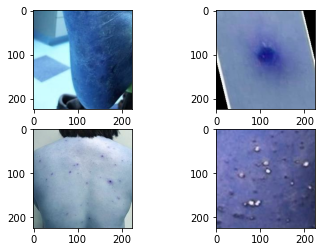

In [127]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [128]:
X_show_all = X_train_all
test = X_test_all

In [129]:
# X_train_all = X_train_all/255
# X_test_all=X_test_all/255

In [130]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [132]:
X_train_all = preprocess_input(X_train_all)

X_test_all = preprocess_input(X_test_all)

X_val_all = preprocess_input(X_val_all)

In [133]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

In [134]:
for layer in base_model.layers:
    layer.trainable = False

In [135]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [154]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)

model = Model(base_model.input, X)

In [155]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [156]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [157]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath='bestmodel.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

es = EarlyStopping( monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1)

cb = [mc, es]

In [158]:
model.fit(X_train_all, y_train_all, batch_size=64, epochs=15, validation_data=(X_val_all, y_val_all), callbacks=cb)

Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.7857
Epoch 1: val_accuracy improved from -inf to 0.60238, saving model to bestmodel.h5
34/34 [==============================] - 102s 3s/step - loss: 1.0623 - accuracy: 0.7857 - val_loss: 1.8296 - val_accuracy: 0.6024
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.9547
Epoch 2: val_accuracy improved from 0.60238 to 0.65476, saving model to bestmodel.h5
34/34 [==============================] - 101s 3s/step - loss: 0.1281 - accuracy: 0.9547 - val_loss: 1.6774 - val_accuracy: 0.6548
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9907
Epoch 3: val_accuracy did not improve from 0.65476
34/34 [==============================] - 75s 2s/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 1.7892 - val_accuracy: 0.6214
Epoch 4/15
34/34 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9977
Epoch 4: val_accu

In [141]:
y_train_all

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [142]:
model.evaluate(X_test_all, y_test_all)

2/2 [==============================] - 2s 359ms/step - loss: 2.0948 - accuracy: 0.7556


[2.094817876815796, 0.7555555701255798]